<a href="https://colab.research.google.com/github/ICam99/cdsi2025/blob/main/practica01/practica01_Ignacio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#!pip install librosa numpy soundfile pydub scikit-learn

# Práctica 1: Sensado y análisis de audio

Se importan las librerías que se utilizarán en el Notebook.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Se definen las direcciones donde están guardados los audios.

*   En cada carpeta de METODO, hay carpetas con el nombre de la persona, y dentro de estas carpetas, los audios específicos de esa persona usando ese método.
*   E.g. content/drive/MyDrive/CDSI/Practica01/AUDIO/METODO1/Ignacio/Ignacio-01_01.mp3

In [9]:
audio_file_path_m1 = "/content/drive/MyDrive/CDSI/Practica01/AUDIO/METODO1"
audio_file_path_m2 = "/content/drive/MyDrive/CDSI/Practica01/AUDIO/METODO2"
audio_file_path_m3 = "/content/drive/MyDrive/CDSI/Practica01/AUDIO/METODO3"

## Método 1

Comenzamos generando un dataframe con los audios del método1. Haciendo extracción de características para añadir a sus columnas (MFCCs, centroides espectrales, Zero Crossing Rate, Root Mean Square Energy, etc). Se añade también la columna "clase" donde se guarda el nombre de la persona que toma su asistencia.

In [10]:
import os
def load_audio_features(audio_file_path):
    features = []
    for root, dirs, files in os.walk(audio_file_path):
        for filename in files:
            if filename.endswith(('.wav', '.mp3', '.m4a', '.ogg', '.opus')):
                filepath = os.path.join(root, filename)
                y, sr = librosa.load(filepath)
                # Extracción de características
                chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
                rmse = np.mean(librosa.feature.rms(y=y))
                spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
                spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
                rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
                zcr = np.mean(librosa.feature.zero_crossing_rate(y))
                mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
                class_name = os.path.basename(root)

                features.append([filename, class_name, chroma_stft, rmse, spec_cent, spec_bw, rolloff, zcr] + list(mfcc))

    header = ['filename', 'class', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate']
    mfccs = [f'mfcc{i}' for i in range(1, 14)]
    header += mfccs
    df = pd.DataFrame(features, columns=header)
    return df

# Se utiliza la funcion definida para cargar el dataset del método 1
df_m1 = load_audio_features(audio_file_path_m1)
print(df_m1.head())


            filename    class  chroma_stft      rmse  spectral_centroid  \
0  Vanessa-01_05.m4a  Vanessa     0.427219  0.053580        2015.367321   
1  Vanessa-01_01.m4a  Vanessa     0.374819  0.058794        1799.808122   
2  Vanessa-01_02.m4a  Vanessa     0.317758  0.096224        1771.088419   
3  Vanessa-01_04.m4a  Vanessa     0.357116  0.073850        1983.370684   
4  Vanessa-01_03.m4a  Vanessa     0.365609  0.077644        1818.937653   

   spectral_bandwidth      rolloff  zero_crossing_rate       mfcc1  \
0         2259.803101  4077.152507            0.092290 -328.897583   
1         2159.172366  3584.132937            0.071066 -327.008270   
2         2151.373317  3774.366760            0.070374 -254.947678   
3         2311.895325  4115.838686            0.076046 -279.952332   
4         2217.117850  3715.806749            0.068920 -319.515472   

        mfcc2  ...      mfcc4      mfcc5      mfcc6      mfcc7     mfcc8  \
0   95.221016  ...   9.466712  11.957688   8.619892 

Con nuestro dataframe generado, entrenamos un modelo usando clasificador Gaussian Naive Bayes.

Accuracy: 0.40625
F1-score: 0.390625


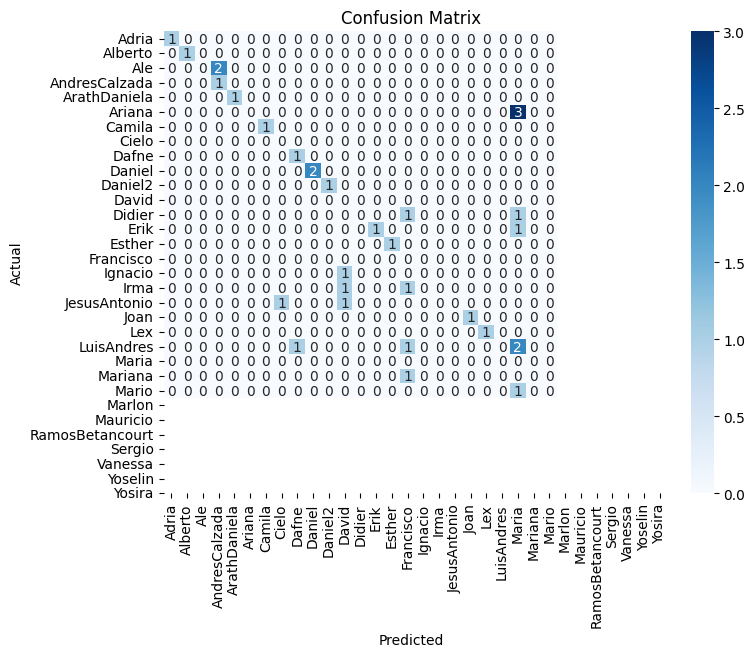

In [40]:
X = df_m1.drop(['class','filename'], axis=1)
y = df_m1['class']

# Se hace la separación en test y train con el tamaño del test siendo 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Se inicializa y se entrena el clasificador de Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Se hacen las predicciones
y_pred = gnb.predict(X_test)

# Evaluación del modelo con f1 score y accuracy
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted') # Use 'weighted' for multi-class

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")

# Se despliega la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=gnb.classes_, yticklabels=gnb.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Nuestro modelo inicial deja mucho que desear. Generamos una clase nula y realizamos aumento de datos, y luego entrenamos de nuevo para comparar sus puntajes después de estos cambios.

In [12]:
# Función para generación de audio para la clase nula

def generate_null_audio(duration=5, sr=22050):
  # Genera silencio
  null_audio = np.zeros(int(duration * sr))
  return null_audio

null_audio = generate_null_audio()

In [ ]:
# Función que genera audios adicionales con tecnicas de procesamiento para aumentar el tamaño del dataframe

def augment_audio(audio_file_path, output_dir, num_augmentations=5):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    y, sr = librosa.load(audio_file_path)
    class_name = os.path.basename(os.path.dirname(audio_file_path))
    filename = os.path.splitext(os.path.basename(audio_file_path))[0]

    for i in range(num_augmentations):
        # Time Stretching
        stretch_factor = np.random.uniform(0.8, 1.2)
        y_stretched = librosa.effects.time_stretch(y, rate=stretch_factor)
        output_filename_stretch = f"{filename}_stretch_{i+1}.wav"
        output_filepath_stretch = os.path.join(output_dir, class_name, output_filename_stretch)
        os.makedirs(os.path.dirname(output_filepath_stretch), exist_ok=True)
        import soundfile as sf
        sf.write(output_filepath_stretch, y_stretched, sr)

        # Pitch Shifting
        n_steps = np.random.randint(-2, 3)
        y_pitched = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
        output_filename_pitch = f"{filename}_pitch_{i+1}.wav"
        output_filepath_pitch = os.path.join(output_dir, class_name, output_filename_pitch)
        os.makedirs(os.path.dirname(output_filepath_pitch), exist_ok=True)
        sf.write(output_filepath_pitch, y_pitched, sr)

output_directory = "/content/drive/MyDrive/CDSI/Practica01/AUDIO/AudioAumentado"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

for root, _, files in os.walk(audio_file_path_m1):
    for filename in files:
        if filename.endswith(('.wav', '.mp3', '.m4a', '.ogg', '.opus')):
            audio_path = os.path.join(root, filename)
            if os.path.exists(audio_path):
                augment_audio(audio_path, output_directory, 5)
            else:
                print(f"File not found: {audio_path}")

df_augmented = load_audio_features("/content/drive/MyDrive/CDSI/Practica01/AUDIO/AudioAumentado")
df_combined = pd.concat([df_m1, df_augmented], ignore_index=True)
print(df_combined.head())

In [14]:
# Se crea un dataframe con datos nulos
null_data = pd.DataFrame(np.nan, index=range(10), columns=df_combined.columns)

# Se crea la clase "Null"
null_data['class'] = 'Null'

# Se combinan los datos de este dataframe con el dataframe existente
df_combined = pd.concat([df_combined, null_data], ignore_index=True)

print(df_combined.tail(15)) #Se checan los últimos 15 elementos para verificar que se han añadido

                     filename class  chroma_stft      rmse  spectral_centroid  \
1755  AleM-01_3_stretch_3.wav   Ale     0.269437  0.025167        1458.465086   
1756  AleM-01_3_stretch_4.wav   Ale     0.273745  0.027582        1460.776225   
1757  AleM-01_3_stretch_5.wav   Ale     0.289115  0.029496        1429.382406   
1758    AleM-01_3_pitch_4.wav   Ale     0.308874  0.029370        1336.865203   
1759    AleM-01_3_pitch_5.wav   Ale     0.271659  0.027124        1566.232702   
1760                      NaN  Null          NaN       NaN                NaN   
1761                      NaN  Null          NaN       NaN                NaN   
1762                      NaN  Null          NaN       NaN                NaN   
1763                      NaN  Null          NaN       NaN                NaN   
1764                      NaN  Null          NaN       NaN                NaN   
1765                      NaN  Null          NaN       NaN                NaN   
1766                      Na

Accuracy: 0.9717514124293786
F1-score: 0.9720754491375961


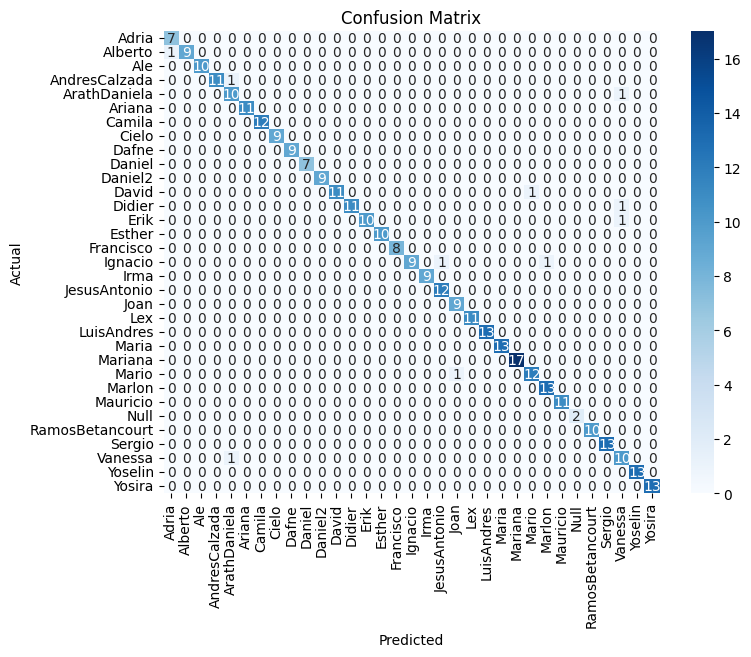

In [15]:
# Corre nuevamente el naive bayes, ahora sobre el nuevo dataframe con los datos aumentado y clase nula.

X = df_combined.drop(['class','filename'], axis=1)
y = df_combined['class']

X = X.fillna(X.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted') # Use 'weighted' for multi-class

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=gnb.classes_, yticklabels=gnb.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Tenemos un modelo bastante bueno, incluso sin haber realizado aún selección de características. Se seleccionan las k=7 mejores características y se vuelve a entrenar el modelo:

Selected features: Index(['rmse', 'spectral_bandwidth', 'mfcc1', 'mfcc3', 'mfcc4', 'mfcc5',
       'mfcc6'],
      dtype='object')
Accuracy with Feature Selection: 0.8587570621468926
F1-score with Feature Selection: 0.857928161317759


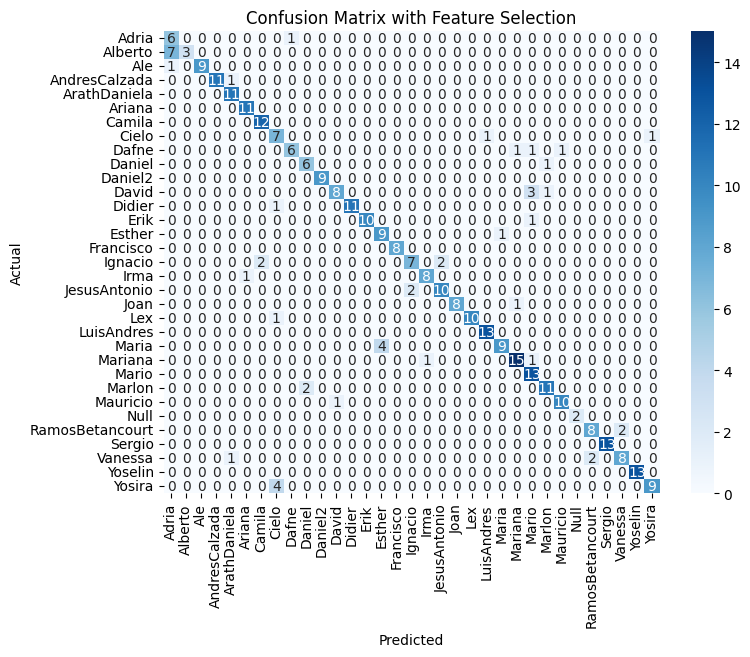

In [16]:
# Utilizando selección de características para reducir las variables del dataframe vuelve a entrenar el modelo

from sklearn.feature_selection import SelectKBest, f_classif

k = 7  # Número de características a seleccionar
selector = SelectKBest(score_func=f_classif, k=k)
X_new = selector.fit_transform(X, y)

# Consigue los índices de las características seleccionadas
selected_feature_indices = selector.get_support(indices=True)

# Consigue los nombres de las características seleccionadas
selected_feature_names = X.columns[selected_feature_indices]
print("Selected features:", selected_feature_names)

X_train_new, X_test_new, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

gnb = GaussianNB()
gnb.fit(X_train_new, y_train)

y_pred_new = gnb.predict(X_test_new)

accuracy_new = accuracy_score(y_test, y_pred_new)
f1_new = f1_score(y_test, y_pred_new, average='weighted')

print(f"Accuracy with Feature Selection: {accuracy_new}")
print(f"F1-score with Feature Selection: {f1_new}")

cm_new = confusion_matrix(y_test, y_pred_new)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues',
            xticklabels=gnb.classes_, yticklabels=gnb.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Feature Selection')
plt.show()

Realizando selcción de características tenemos un modelo con menor accuracy y f1 score que el original (se intentaron también k=3, k=15, y k=11). Por este motivo dejaremos de lado la selcción de características para los siguientes modelos.

## Método 2

Accuracy: 0.9887005649717514
F1-score: 0.9886797700602662


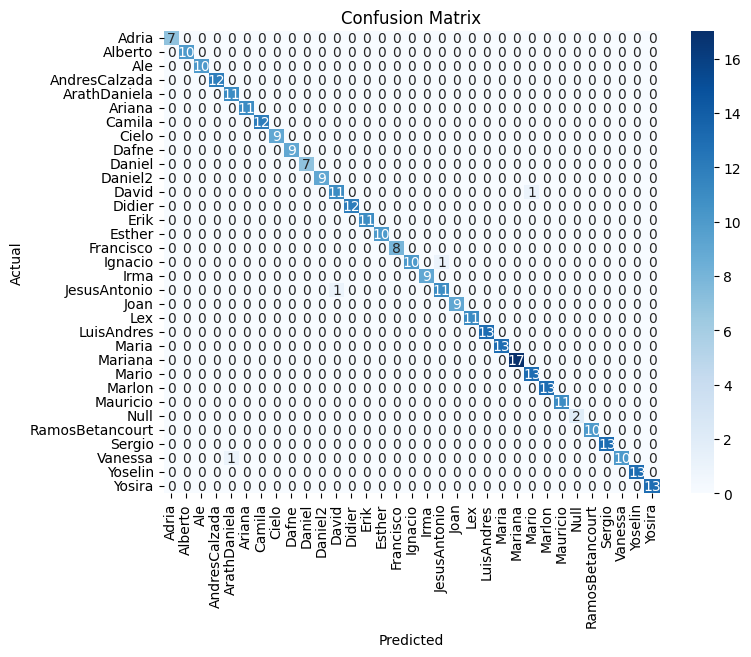

In [17]:
# Genera un modelo usando Random Forest para los audios utilizando el método 2

output_directory_m2 = "/content/drive/MyDrive/CDSI/Practica01/AUDIO/AudioAumentado_Metodo2"
if not os.path.exists(output_directory_m2):
    os.makedirs(output_directory_m2)

df_m2 = load_audio_features(audio_file_path_m2)

# Aumento de datos para los archivos del método 2
for root, _, files in os.walk(audio_file_path_m2):
    for filename in files:
        if filename.endswith(('.wav', '.mp3', '.m4a', '.ogg', '.opus')):
            audio_path = os.path.join(root, filename)
            if os.path.exists(audio_path):
                augment_audio(audio_path, output_directory_m2, 5)
            else:
                print(f"File not found: {audio_path}")

df_augmented_m2 = load_audio_features(output_directory_m2)

df_combined_m2 = pd.concat([df_m2, df_augmented_m2], ignore_index=True)

# Se añaden los datos de la clase nula
null_data_m2 = pd.DataFrame(np.nan, index=range(10), columns=df_combined_m2.columns)
null_data_m2['class'] = 'Null'
df_combined_m2 = pd.concat([df_combined_m2, null_data_m2], ignore_index=True)

# Se inicializa y se entrena el clasificador de Random Forest
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=rfc.classes_, yticklabels=rfc.classes_) # Use rfc.classes_
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Método 3

Accuracy: 0.9124293785310734
F1-score: 0.9126794812009191


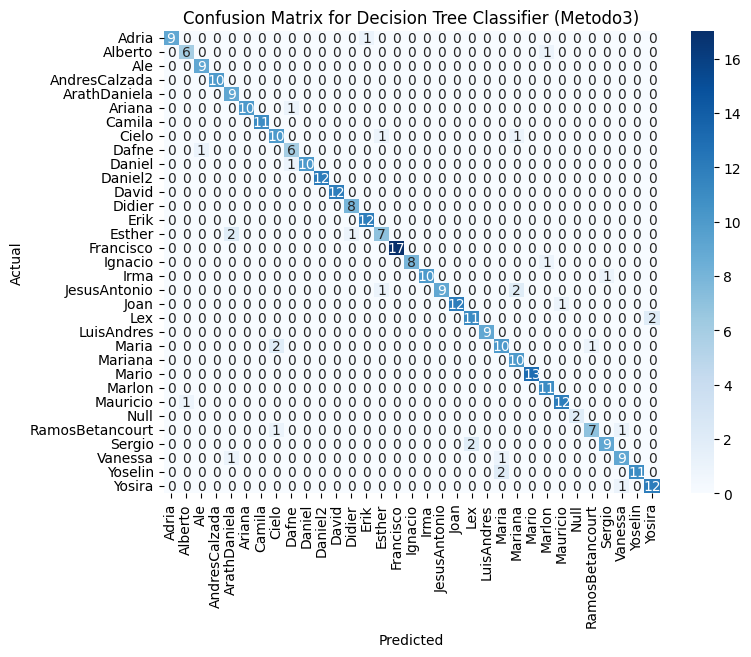

In [18]:
# Se genera ahora el dataframe con los audios del método 3

output_directory_m3 = "/content/drive/MyDrive/CDSI/Practica01/AUDIO/AudioAumentado_Metodo3"
if not os.path.exists(output_directory_m3):
    os.makedirs(output_directory_m3)

df_m3 = load_audio_features(audio_file_path_m3)

for root, _, files in os.walk(audio_file_path_m3):
    for filename in files:
        if filename.endswith(('.wav', '.mp3', '.m4a', '.ogg', '.opus')):
            audio_path = os.path.join(root, filename)
            if os.path.exists(audio_path):
                augment_audio(audio_path, output_directory_m3, 5)
            else:
                print(f"File not found: {audio_path}")

df_augmented_m3 = load_audio_features(output_directory_m3)

df_combined_m3 = pd.concat([df_m3, df_augmented_m3], ignore_index=True)

null_data_m3 = pd.DataFrame(np.nan, index=range(10), columns=df_combined_m3.columns)
null_data_m3['class'] = 'Null'
df_combined_m3 = pd.concat([df_combined_m3, null_data_m3], ignore_index=True)

X = df_combined_m3.drop(['class','filename'], axis=1)
y = df_combined_m3['class']
X = X.fillna(X.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dtc.classes_, yticklabels=dtc.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree Classifier (Metodo3)')
plt.show()

## Validación cruzada

In [19]:
# Se evalúan los modelos utilizando validación cruzada

from sklearn.model_selection import cross_val_score, KFold

def evaluate_model_with_cross_validation(model, X, y, cv=5):
    kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')

    print(f"Cross-Validation Scores: {scores}")
    print(f"Mean Accuracy: {np.mean(scores)}")
    print(f"Standard Deviation: {np.std(scores)}")

# Gaussian Naive Bayes
print("Evaluando Gaussian Naive Bayes:")
evaluate_model_with_cross_validation(gnb, X, y)

# RandomForest
print("\nEvaluabdo RandomForest:")
evaluate_model_with_cross_validation(rfc, X, y)

# Decision Tree
print("\nEvaluating Decision Tree:")
evaluate_model_with_cross_validation(dtc, X, y)

Evaluating Gaussian Naive Bayes:
Cross-Validation Scores: [0.94915254 0.96327684 0.96327684 0.9519774  0.94067797]
Mean Accuracy: 0.9536723163841808
Standard Deviation: 0.008679260732054883

Evaluating RandomForest:
Cross-Validation Scores: [0.99717514 1.         0.99435028 1.         0.99717514]
Mean Accuracy: 0.9977401129943504
Standard Deviation: 0.0021139307269909136

Evaluating Decision Tree:
Cross-Validation Scores: [0.91242938 0.9519774  0.92372881 0.93785311 0.91525424]
Mean Accuracy: 0.9282485875706215
Standard Deviation: 0.014797515088936517


Después de observar los 3 modelos, iremos con el modelo generado usando RandomForest y método 2.

## Prueba en vivo

Primero se genera la función que nos permite grabar el audio. Esta grabación dura 3 segundos.

In [20]:
from google.colab import output
from IPython.display import Javascript

def record_audio(filename="audio.wav", duration=3):
    display(Javascript(f"""
        var my_div = document.createElement("DIV");
        var my_p = document.createElement("P");
        my_p.appendChild(document.createTextNode("Grabando..."));
        my_div.appendChild(my_p);
        document.body.appendChild(my_div);

        navigator.mediaDevices.getUserMedia({{ audio: true }}).then(stream => {{
            var mediaRecorder = new MediaRecorder(stream);
            var audioChunks = [];
            mediaRecorder.ondataavailable = event => {{
                audioChunks.push(event.data);
            }};
            mediaRecorder.onstop = event => {{
                var audioBlob = new Blob(audioChunks);
                var reader = new FileReader();
                reader.readAsDataURL(audioBlob);
                reader.onloadend = function() {{
                    var base64data = reader.result.split(',')[1];
                    google.colab.kernel.invokeFunction('notebook.record_audio', [base64data, "{filename}"], {{}});
                }};
            }};
            setTimeout(() => mediaRecorder.stop(), {duration * 1000});
            mediaRecorder.start();
        }});
    """))

import base64
import numpy as np
import soundfile as sf

def save_audio(base64data, filename):
    audio_bytes = base64.b64decode(base64data)
    with open(filename, "wb") as f:
        f.write(audio_bytes)
    print(f"Audio guardado como {filename}")

output.register_callback('notebook.record_audio', save_audio)

In [21]:
def extract_features(filename="audio.wav", sr=16000):
       y, sr = librosa.load(filename, sr=sr)

       chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
       rmse = np.mean(librosa.feature.rms(y=y))
       spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
       spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
       rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
       zcr = np.mean(librosa.feature.zero_crossing_rate(y))
       mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
       features = np.array([chroma_stft, rmse, spec_cent, spec_bw, rolloff, zcr] + list(mfcc))
       return features

In [41]:
# Carga el modelo RandomForest y se utiliza para predecir quien esta hablando en una prueba en tiempo real

def predict_speaker(filename="audio.wav", model=rfc):
    try:
        features = extract_features(filename)
        features = features.reshape(1, -1)
        prediction = model.predict(features)[0]
        print(f"Predicción: El hablante es {prediction}")
        return prediction
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

## Prueba en tiempo real - paso 1

Simplemente se ejecuta la siguiente línea de código. Se grabará el audio por los siguientes 3 segundos. Una vez que el audio sea grabado, aparecerá un mensaje "Audio guardado como audio.wav".

In [ ]:
record_audio()

## Prueba en tiempo real - paso 2

Después de haber ejecutado la línea anterior para grabar el audio, se ejecuta la siguiente línea, con la cual el modelo intentará predecir la persona tomando su asistencia.

In [ ]:
predicted_speaker = predict_speaker()